# Nesse notebook construimos e visualizamos a arquitetura de atenção de um Transformer, usando tanto Keras quanto ferramentas como bertviz. Vou te explicar o que está sendo feito em cada parte relevante, com foco na arquitetura de atenção:

#### Requirements

In [19]:
# Run this cell to install some required packages:
# !pip install keras-nlp pydot bertviz

# Visualizing the flow of a model

### Demonstrating projection

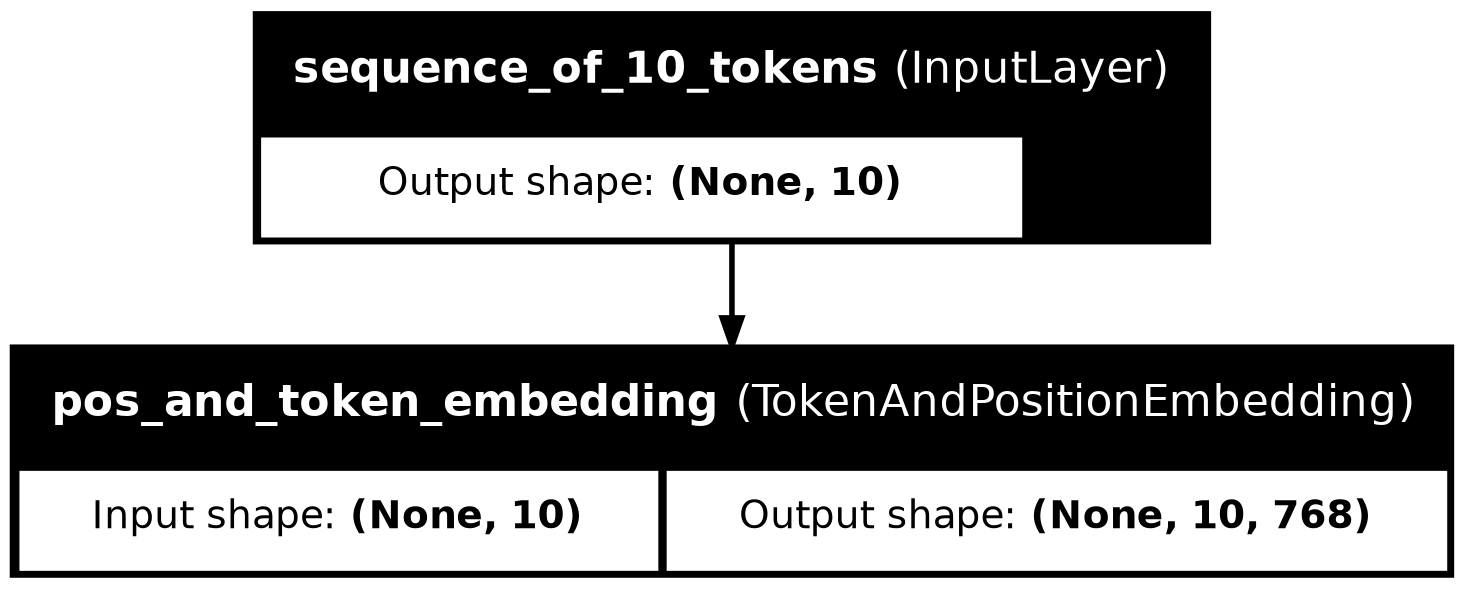

In [20]:
from keras_nlp.layers import TokenAndPositionEmbedding
from tensorflow.keras.layers import Input, LayerNormalization, Dense, Embedding
from tensorflow.keras import Sequential, Model
import tensorflow as tf

# Imagine an input sequence of 10 tokens
input_layer = Input(shape = (10,), name = "sequence_of_10_tokens")
# This layer takes our tokens and gives them both word and pos embeddings
embedding_layer = TokenAndPositionEmbedding(20, 10, 768, name = "pos_and_token_embedding")(input_layer)

# For visualization purposes
first_embeddings = Model(inputs = input_layer, outputs = embedding_layer)
tf.keras.utils.plot_model(first_embeddings,  show_shapes=True, show_layer_names=True)

### Demonstrating passing to FFN

In [21]:
from keras.layers import Lambda
import tensorflow as tf

# Dot product with scaling and softmax, inside a Lambda layer
def scaled_dot_product_attention(query, key, value, d_model):
    dot_product = Lambda(lambda x: tf.matmul(x[0], x[1], transpose_b=True))([query, key])
    scale = Lambda(lambda x: x / tf.math.sqrt(tf.cast(d_model, tf.float32)))(dot_product)
    softmaxed = Lambda(lambda x: tf.nn.softmax(x, axis=-1))(scale)
    output = Lambda(lambda x: tf.matmul(x[0], x[1]))([softmaxed, value])
    return output

# Exemplo
d_model = 2
query = Dense(d_model, name="query_projection")(embedding_layer)
key = Dense(d_model, name="key_projection")(embedding_layer)
value = Dense(d_model, name="value_projection")(embedding_layer)

attention_output = scaled_dot_product_attention(query, key, value, d_model)

### Putting it all together

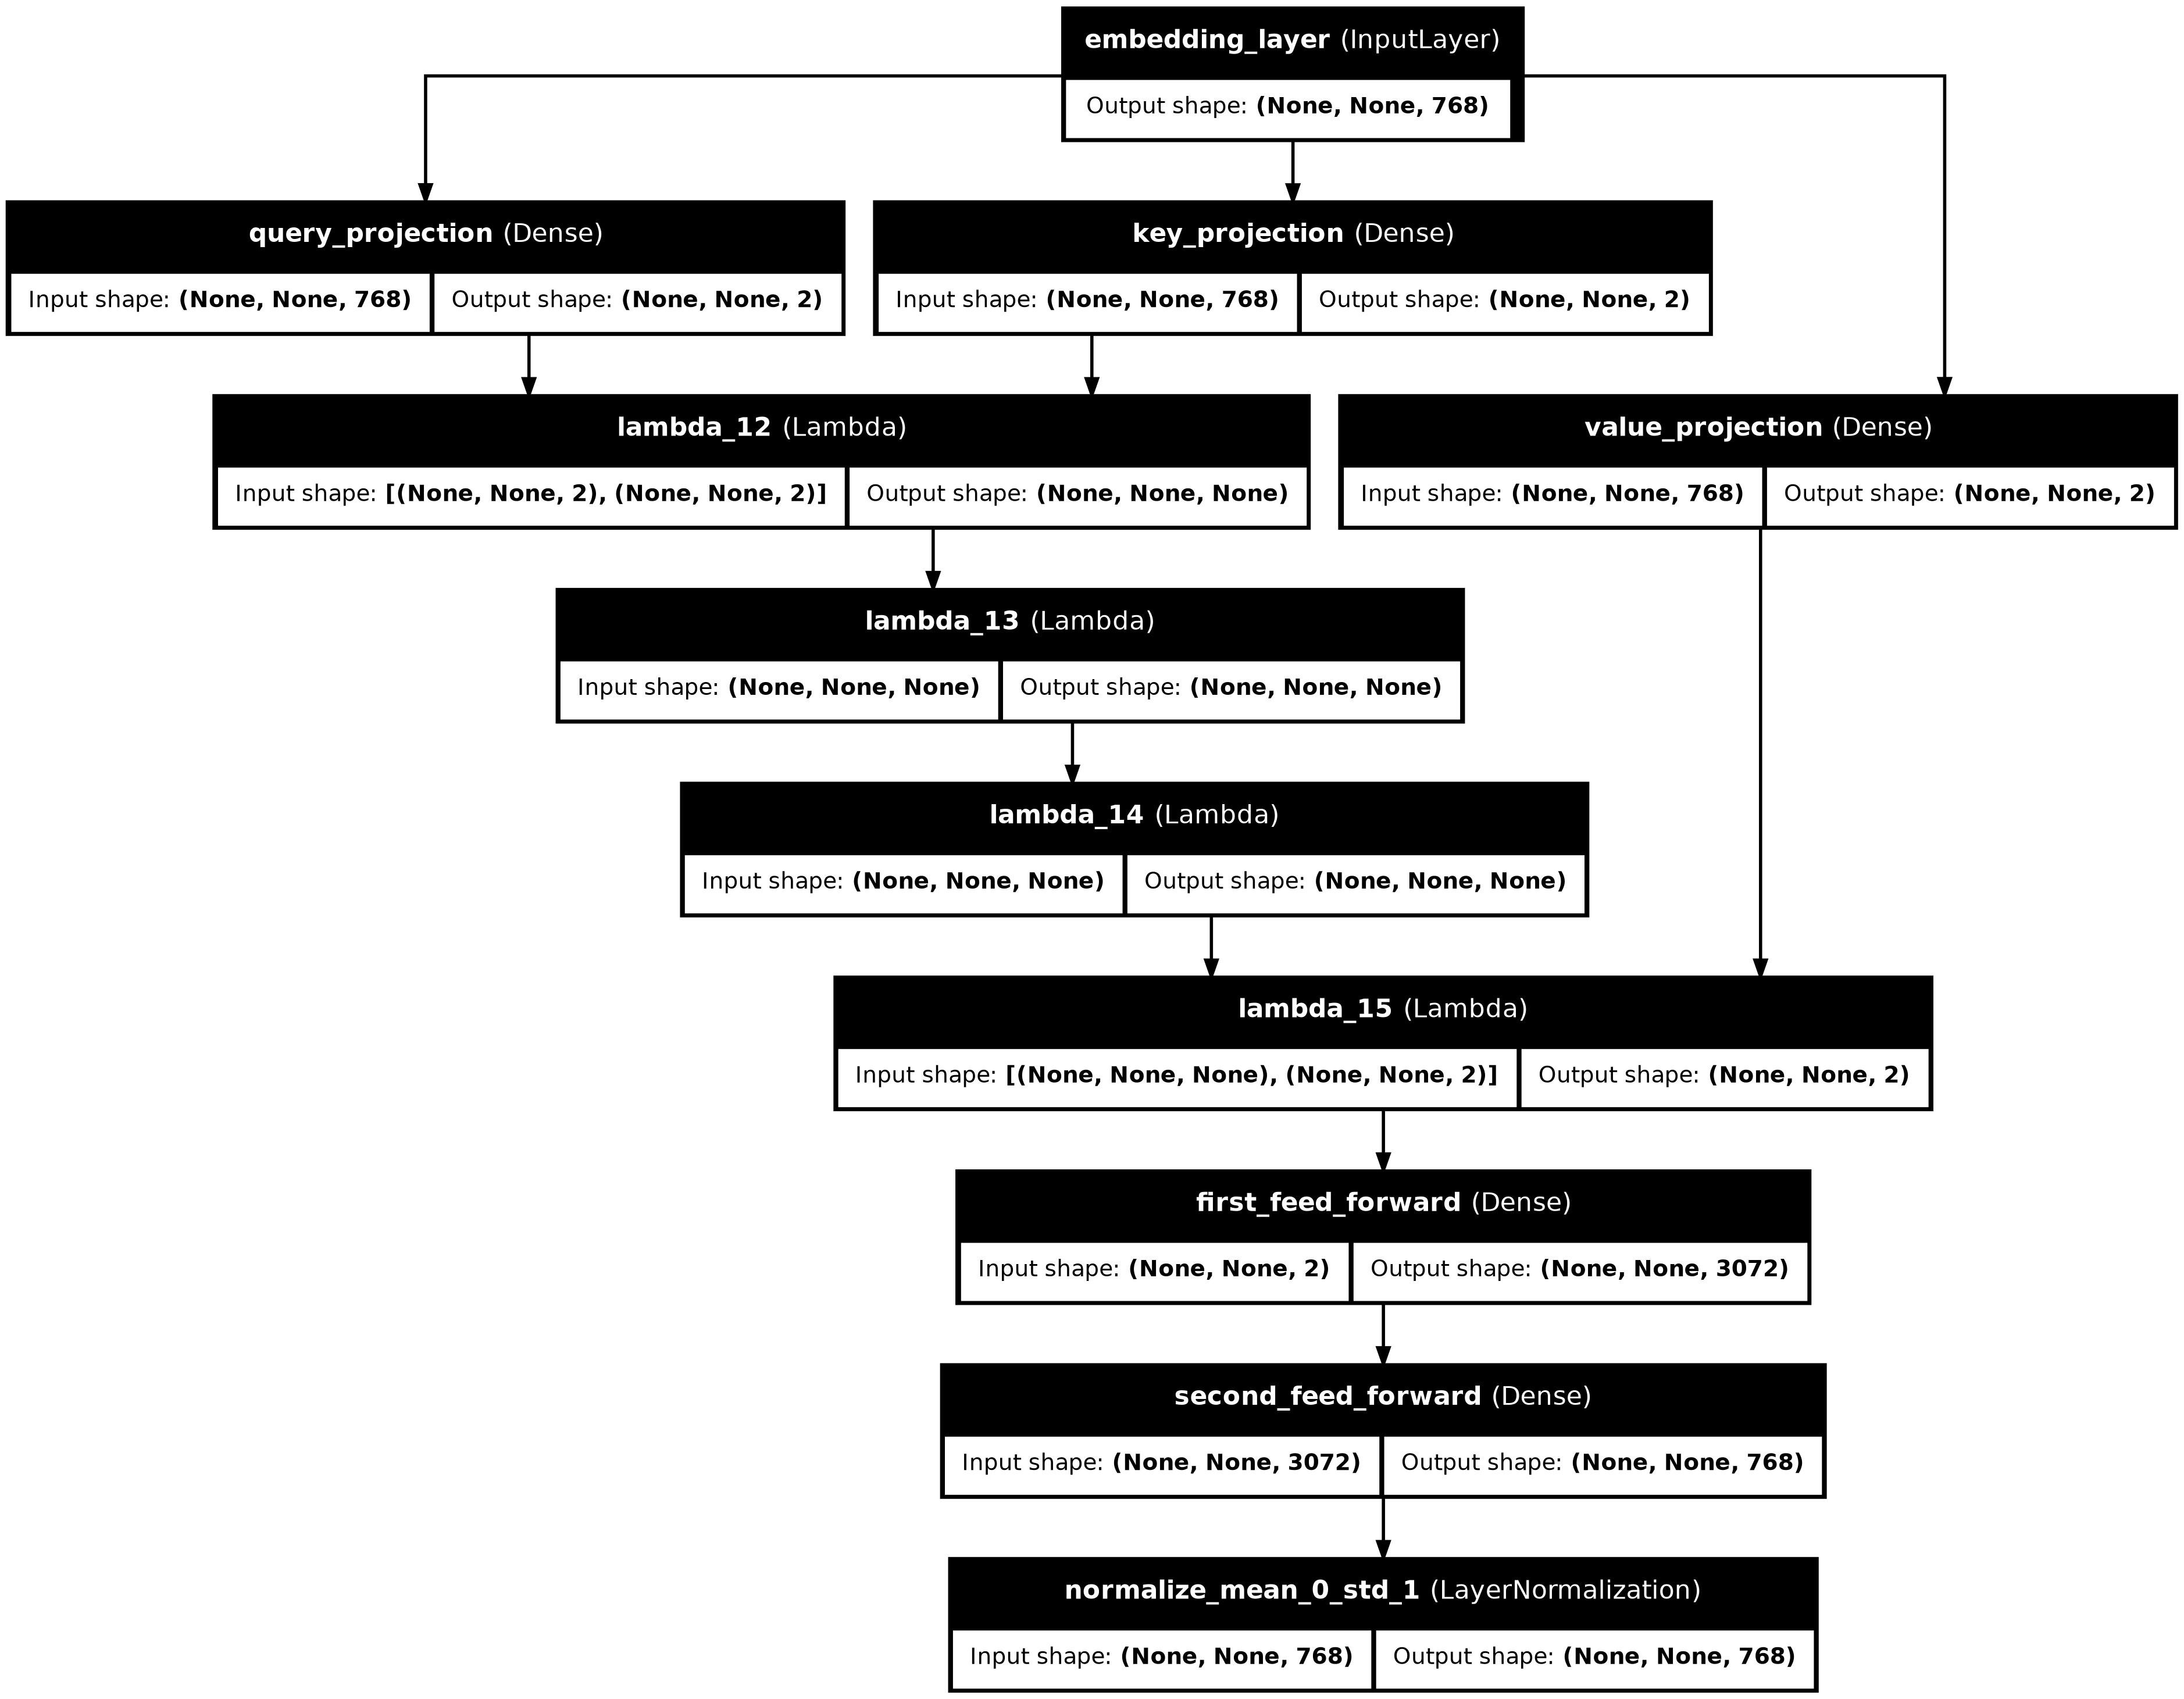

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, LayerNormalization
from tensorflow.keras.models import Model

# Input layer
input_layer = Input(shape=(None, 768), name="embedding_layer")

# Projeções para Q, K, V
query = Dense(2, name="query_projection")(input_layer)
key = Dense(2, name="key_projection")(input_layer)
value = Dense(2, name="value_projection")(input_layer)

# Atenção Escalonada
def scaled_dot_product_attention(query, key, value, d_model):
    dot_product = Lambda(lambda x: tf.matmul(x[0], x[1], transpose_b=True))([query, key])
    scale = Lambda(lambda x: x / tf.math.sqrt(tf.cast(d_model, tf.float32)))(dot_product)
    softmaxed = Lambda(lambda x: tf.nn.softmax(x, axis=-1))(scale)
    output = Lambda(lambda x: tf.matmul(x[0], x[1]))([softmaxed, value])
    return output

d_model = 2
z = scaled_dot_product_attention(query, key, value, d_model)

# Feed-forward network
ff_1 = Dense(4 * 768, activation='relu', name="first_feed_forward")(z)
ff_2 = Dense(768, name="second_feed_forward")(ff_1)
ffn_output = LayerNormalization(name="normalize_mean_0_std_1")(ff_2)

# Modelo final
full_block = Model(inputs=input_layer, outputs=ffn_output)

# Visualizar arquitetura
tf.keras.utils.plot_model(full_block, show_shapes=True, show_layer_names=True)

# Visualization with BertViz

In [23]:
from bertviz import head_view
from transformers import AutoModel, AutoTokenizer

model = AutoModel.from_pretrained("bert-base-uncased", output_attentions = True)

first_sentence = "The lawyer worked on the case"
second_sentence = "I pushed shift to make the letters upper case"

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
viz_input = tokenizer(first_sentence, second_sentence, return_tensors = "pt")
attention = model(**viz_input).attentions
starter = (viz_input.token_type_ids == 0).sum(dim = 1)
tokens = tokenizer.convert_ids_to_tokens(viz_input.input_ids[0])
head_view(attention, tokens, starter, heads = [8])

<IPython.core.display.Javascript object>

# `transformers` pipelines

In [24]:
from transformers import pipeline
pipe = pipeline("translation", model="Helsinki-NLP/opus-mt-en-fr")

Device set to use cuda:0


In [25]:
result = pipe("I am a student and I am studying in London")
result[0]['translation_text']

"Je suis étudiante et j'étudie à Londres."

### Pipelines under the hood (a Tensorflow variation)

In [26]:
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-fr")

tokens = tokenizer.encode("This is easy!", return_tensors = "tf")

print(tokens)

tf.Tensor([[ 160   32 3120  145    0]], shape=(1, 5), dtype=int32)


In [27]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-fr")
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-fr")

input_text = "The weather is nice today."
inputs = tokenizer(input_text, return_tensors="pt")
output = model.generate(**inputs)

print(tokenizer.decode(output[0], skip_special_tokens=True))

Le temps est beau aujourd'hui.
